In [1]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *

torch.backends.cudnn.benchmark = True

img_wh = (400, 400)

# dataset = dataset_dict['llff'] \
#           ('/home/ubuntu/data/nerf_example_data/my/silica4/', 'test_train', spheric_poses=True,
#            img_wh=img_wh)

dataset = dataset_dict['blender'] \
          ('./datasets/nerf_synthetic/lego/', 'test',
           img_wh=img_wh)

test2 by Peiyi torch.Size([400, 400, 3])
tensor([[[-0.3600,  0.3600, -1.0000],
         [-0.3582,  0.3600, -1.0000],
         [-0.3564,  0.3600, -1.0000],
         ...,
         [ 0.3546,  0.3600, -1.0000],
         [ 0.3564,  0.3600, -1.0000],
         [ 0.3582,  0.3600, -1.0000]],

        [[-0.3600,  0.3582, -1.0000],
         [-0.3582,  0.3582, -1.0000],
         [-0.3564,  0.3582, -1.0000],
         ...,
         [ 0.3546,  0.3582, -1.0000],
         [ 0.3564,  0.3582, -1.0000],
         [ 0.3582,  0.3582, -1.0000]],

        [[-0.3600,  0.3564, -1.0000],
         [-0.3582,  0.3564, -1.0000],
         [-0.3564,  0.3564, -1.0000],
         ...,
         [ 0.3546,  0.3564, -1.0000],
         [ 0.3564,  0.3564, -1.0000],
         [ 0.3582,  0.3564, -1.0000]],

        ...,

        [[-0.3600, -0.3546, -1.0000],
         [-0.3582, -0.3546, -1.0000],
         [-0.3564, -0.3546, -1.0000],
         ...,
         [ 0.3546, -0.3546, -1.0000],
         [ 0.3564, -0.3546, -1.0000],
         

In [2]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = 'ckpts/exp2/epoch=15.ckpt'
# ckpt_path = 'ckpts/fern/epoch=29.ckpt'
# ckpt_path = 'ckpts/silica3_3/epoch=29.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [3]:
models = [nerf_coarse, nerf_fine]
embeddings = [embedding_xyz, embedding_dir]

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32*4

@torch.no_grad()
def f(rays):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [4]:
sample = dataset[0]
rays = sample['rays'].cuda()

t = time.time()
results = f(rays)
torch.cuda.synchronize()
print(time.time()-t)

test3 by Peiyi tensor([[-1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.7341,  0.6790,  2.7373],
        [ 0.0000,  0.6790,  0.7341,  2.9593]])


/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "


3.1871986389160156


In [5]:
print(sample)

{'rays': tensor([[ 0.0000,  2.7373,  2.9593,  ..., -0.4364,  2.0000,  6.0000],
        [ 0.0000,  2.7373,  2.9593,  ..., -0.4366,  2.0000,  6.0000],
        [ 0.0000,  2.7373,  2.9593,  ..., -0.4368,  2.0000,  6.0000],
        ...,
        [ 0.0000,  2.7373,  2.9593,  ..., -0.8727,  2.0000,  6.0000],
        [ 0.0000,  2.7373,  2.9593,  ..., -0.8723,  2.0000,  6.0000],
        [ 0.0000,  2.7373,  2.9593,  ..., -0.8719,  2.0000,  6.0000]]), 'rgbs': tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]), 'c2w': tensor([[-1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.7341,  0.6790,  2.7373],
        [ 0.0000,  0.6790,  0.7341,  2.9593]]), 'valid_mask': tensor([False, False, False,  ..., False, False, False])}


PSNR 32.80875015258789


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


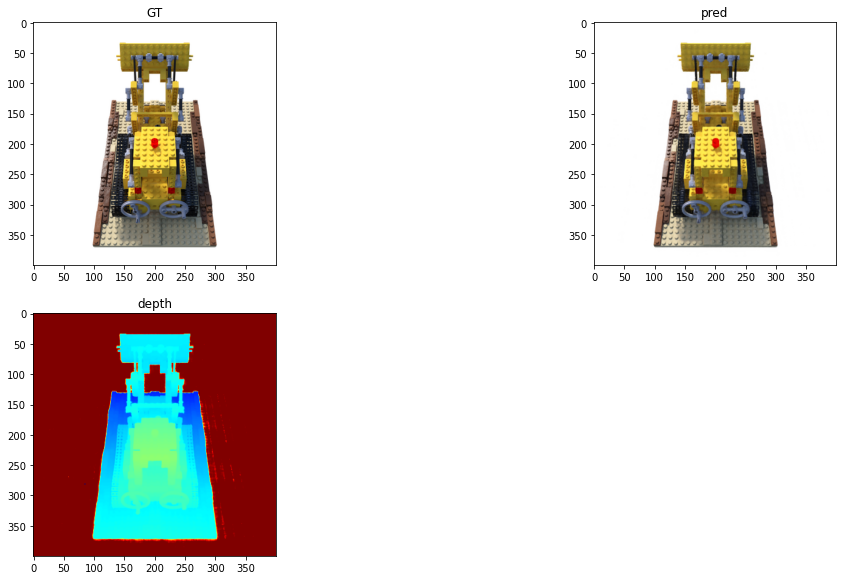

In [7]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()